In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy_healpix import HEALPix
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# need to make pixel mask of CHIME visible area and then compute SNR for this region based on updated t_obs and number of CHIME beams

CPU times: user 23.6 s, sys: 94.5 ms, total: 23.7 s
Wall time: 23.7 s


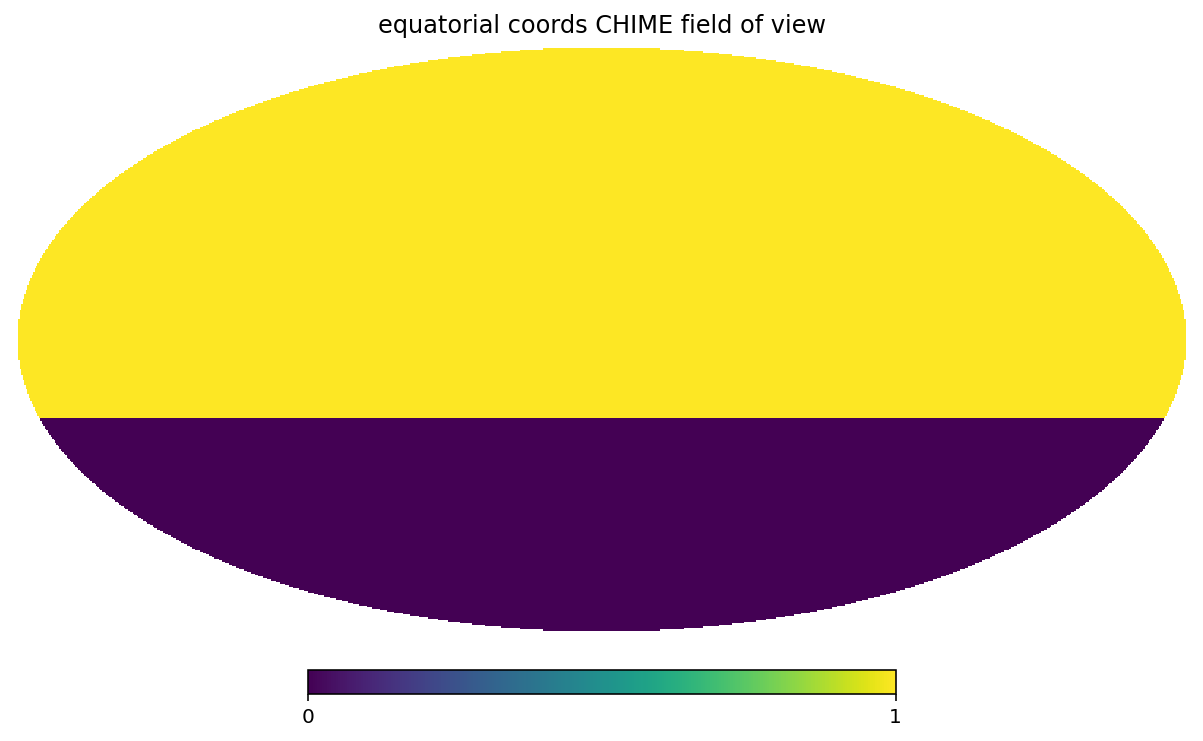

In [2]:
%%time
#to create the map that CHIME sees in equatorial coordiantes

NSIDE = 512
dec_cutoff = -20
mask_map = np.zeros(hp.nside2npix(NSIDE))
#looping over map and taking values above dec_cutoff
for i in range(len(mask_map)):
    ang = hp.pix2ang(NSIDE, i, lonlat=True)
    #checking that pixel is above CHIME cutoff
    if ang[1]>=dec_cutoff:
        mask_map[i] = 1

hp.mollview(mask_map, title='equatorial coords CHIME field of view')


In [3]:
#need function that takes HEALPix pixel in galactic coords and returns HEALPix pixel in equatorial coords,
#so that I can iterate over a blank array and populate it with equatorial values

# I think this can be done by converting pixel into galactic coords, galactic into equatorial, and then eqautorial
# into pixel. I think this can all be done with astropy - healpy packages

In [4]:
#function that takes pixel galactic index and converts into pixel equatorial index. 
#Needs to work for a list of coords so make it vectorized
def gal_pix2eq_pix(gal_pix, NSIDE):
    #converting pixels to galactic coords
    hpix_gal = HEALPix(nside=NSIDE, order='ring', frame=Galactic())
    gal_coord = hpix_gal.healpix_to_skycoord(gal_pix)
    
    
    #converting back to Healpy pixel coordinates
    hpix_eq = HEALPix(nside=NSIDE, order='ring', frame=ICRS())
    eq_pix = hpix_eq.skycoord_to_healpix(gal_coord)
    
    return(eq_pix)

In [5]:
#going to take an np.arange of proper length then apply this vectorized function on it to get a list of transformed
#healpy indices then call the mask_map at that array to get mask in galactic coords. This is vectorized so its good

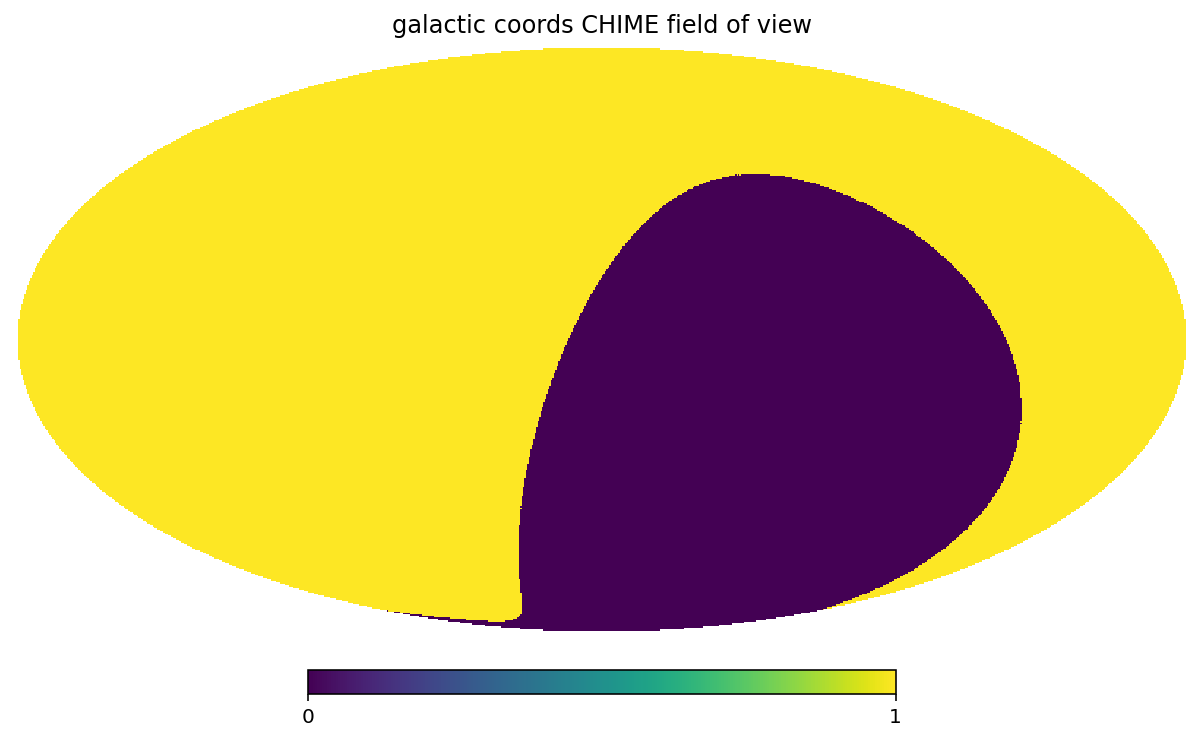

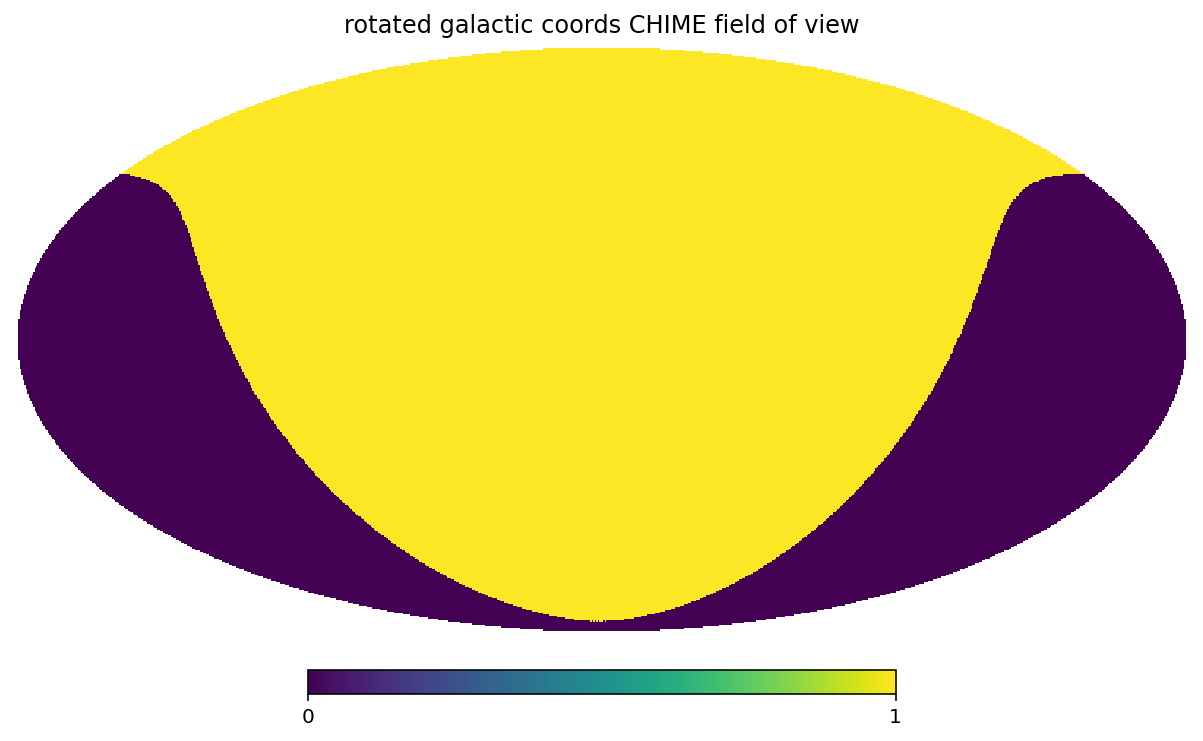

In [6]:
#making a map that is 1 in the CHIME field of view and 0 outside of it
NSIDE = 512
eq_map = gal_pix2eq_pix(np.arange(hp.nside2npix(NSIDE)), NSIDE)
mask_gal_map = mask_map[eq_map]
hp.mollview(mask_gal_map, title='galactic coords CHIME field of view')
hp.mollview(mask_gal_map, title='rotated galactic coords CHIME field of view', rot=(120, 0, 0))

In [7]:
np.savez("mask_gal_map",mask_gal_map)

In [8]:
print("Updated parameters for restricted field of view")
#area of CHIME field of view
pix_area = hp.nside2pixarea(512) #in sr
print("Area of CHIME field of view in sr: ",np.sum(mask_gal_map)*pix_area,"sr")

t_obs = 3.75 * 365.25 * 24 * 3600 * 0.31 * (0.0609235/8.430806347119105)
print("t_obs: ",t_obs, "s")

num_chimes = 8.430806347119105/0.0609235
print("Number of CHIMEs to cover region: ", num_chimes)

Updated parameters for restricted field of view
Area of CHIME field of view in sr:  8.430806347119105 sr
t_obs:  265101.7899312478 s
Number of CHIMEs to cover region:  138.38348662041915


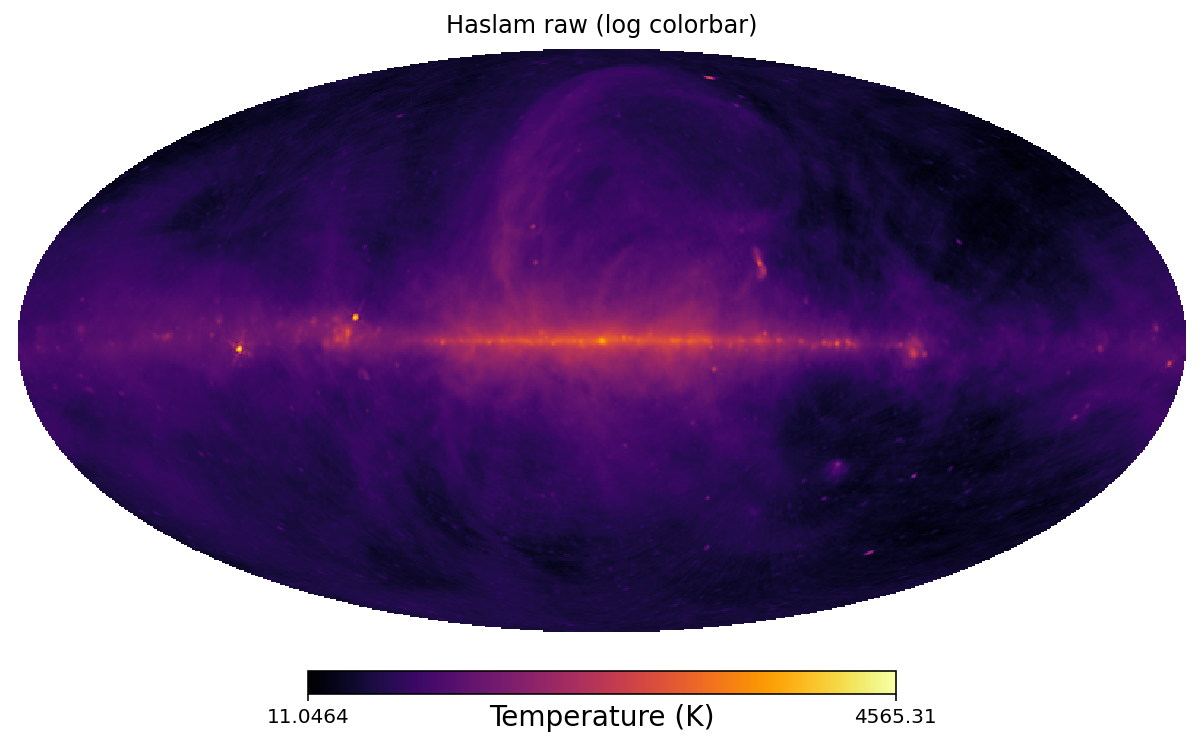

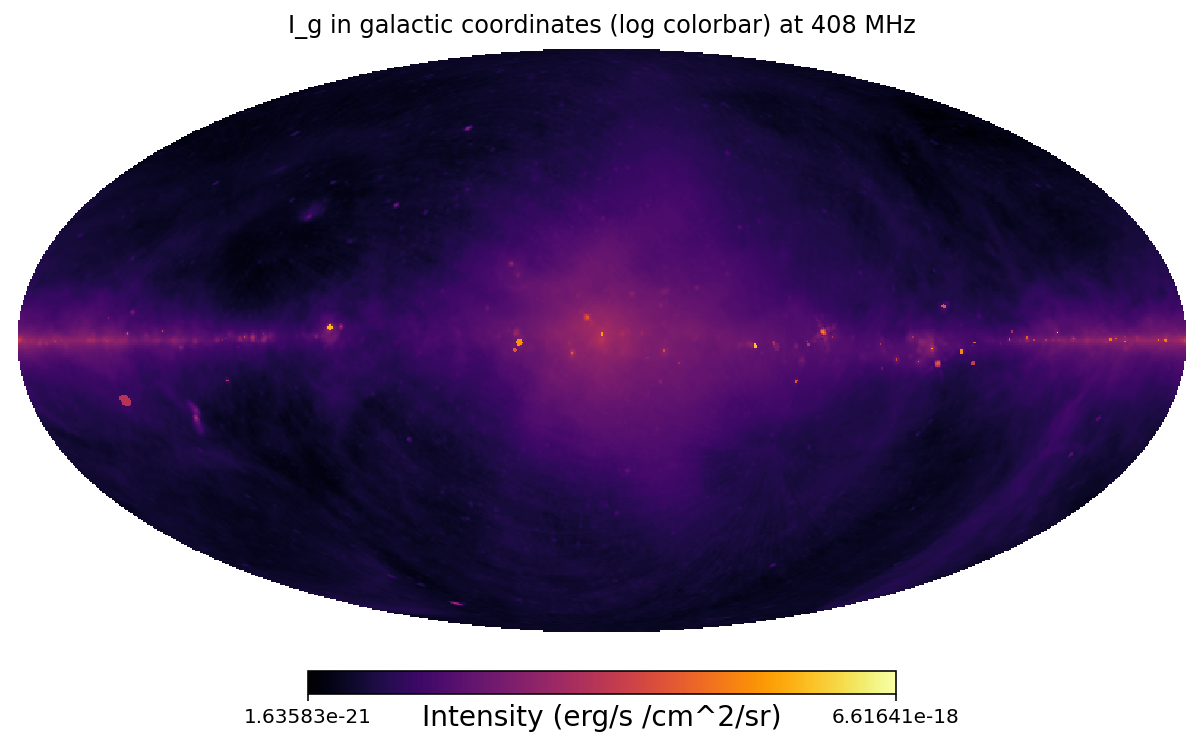

In [9]:
#loading in correct gegenschein(temp and intensity) map and Haslam map
map_raw_address = '/Users/harpersewalls/Desktop/SURA/Haslam_static_map/lambda_haslam408_nofilt.fits'
map_raw = hp.read_map(map_raw_address)/1000 #divide by 1000 to convert mK to K
I_g = np.load('/Users/harpersewalls/Desktop/SURA/Haslam_static_map/sky_maps/Haslam_and_SNR.npz')['arr_0']

#plotting these maps
hp.mollview(map_raw, norm='log', unit='Temperature (K)', title='Haslam raw (log colorbar)', cmap='inferno')
hp.mollview(I_g, norm='log', unit='Intensity (erg/s /cm^2/sr)', title='I_g in galactic coordinates (log colorbar) at 408 MHz', cmap='inferno')

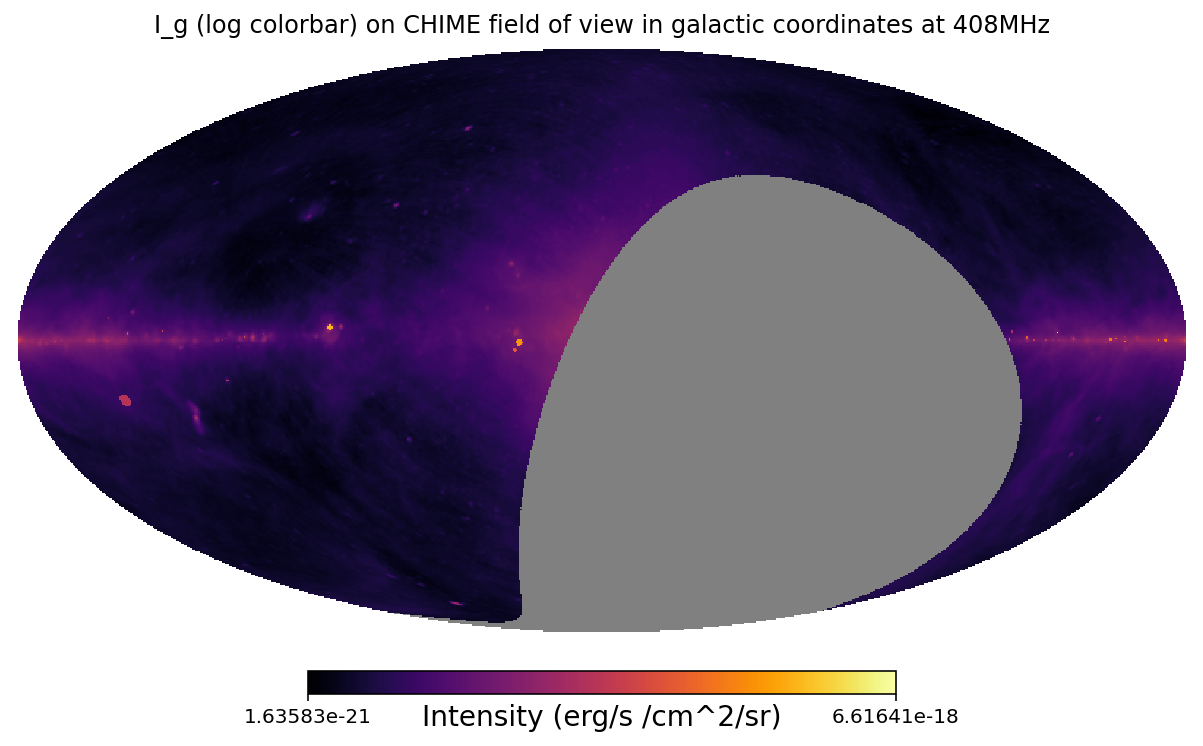

In [10]:
#masking and plotting I_g for use in computations

#making I_g map that has hp.UNSEEN for the masked values

I_g_masked = np.array([I_g[i] if mask_gal_map[i]==1 else hp.UNSEEN for i in range(len(I_g))])
hp.mollview(I_g_masked, norm='log', unit='Intensity (erg/s /cm^2/sr)', title='I_g (log colorbar) on CHIME field of view in galactic coordinates at 408MHz', cmap='inferno')



In [11]:
#making boolean mask that can be used for calculation
field_of_view_mask = [True if i==1 else False for i in mask_gal_map]

In [12]:
#getting gegenschein signal and Haslam signal for CHIME's field of view
Haslam_clipped = map_raw[field_of_view_mask]
I_g_clipped = I_g[field_of_view_mask]

In [21]:
len(Haslam_clipped)

2110476

In [22]:
hp.nside2pixarea(512)*2110476

8.430806347119105

In [13]:
#signal power computation for field of view
f_delta = 0.721
eta_A = 0.5
A_illu = 6.24e7 #cm^2
beam_area = 0.0609235 #sr

#computing signal power over sky
signal_power = f_delta * eta_A * A_illu * I_g_clipped * beam_area

In [14]:
#computing noise power per pixel for field of view
k_b = 1.380649e-16 # Boltzmann's constant in cgs
T_sys = 55 # K according to CHIME whitepaper
#t_obs is probably wrong, I just need to know if it's time that that pixel is observed or total sky, for now 
#doing total sky in absence of beam area information. assuming its been observing for 3.75 years, with data loss
#of 69%
t_obs = 265101.79 #in seconds, computed from total observing time and beam area and field of view size
Delta_nu = 2.17 * (116000/299792458) * 408e6 # using YK formula for delta nu

#now implementing equation 23 with the Haslam map as T_sky
noise_power = 2 * k_b * (T_sys + Haslam_clipped) * np.sqrt(Delta_nu/t_obs)

In [15]:
265101.79/3600/24

3.0683077546296293

In [16]:
SNR_sky = signal_power/noise_power

In [17]:
len(noise_power)/138

15293.304347826086

In [18]:
15293 * 138

2110434

In [27]:
hp.nside2pixarea(512)*15293

0.06109158382587268

In [25]:
len(CHIMES[0])

15293

In [19]:
#now computing SNR for 138 CHIMES covering the sky

#to break sky up into 138 pieces will break the first 3141500 pixels which will divide into 206 evenly. 
SNR_clipped = SNR_sky[:2110434]
CHIMES = np.split(SNR_clipped, 138)

#averaging over sky regions
means = []
for i in CHIMES:
    means.append(np.mean(i))

#summing in quadrature
total_SNR = np.sqrt(np.sum(np.array(means)**2))
print("total_SNR: ", total_SNR)

total_SNR:  3.6362342689514
